# Save Exposure, impact and hail hazard to hdf5 files 

In [30]:
#own
import sys

sys.path.append('C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/code_and_data/')
from utility import data_dir, exposure_from_gpd, read_gridded_damages_as_impact, hazard_from_radar, aggregate_hazard, en_names

# climada
from climada.util.save import load
from climada.entity import ImpactFunc, ImpactFuncSet,Exposures
from climada.engine import ImpactCalc, Impact 
from climada.hazard import Hazard
# others
import numpy as np

n_thresh=1 #in number of fields
croptypes=['Weizen_Mais_Raps_Gerste','Reben','Weizen','Mais','Raps','Gerste','Reben']


In [2]:
for resolution in [8]: # ,4,2,1]:
    for croptype in croptypes:
        if resolution>1:
            exposure_file = f"C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/GIS/{croptype}_{resolution}km.gpkg" #Arealstatistik/'+croptype+'_latlon.hdf5'
        else:
            exposure_file = f"C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/GIS/{croptype}.gpkg" #Arealstatistik/'+croptype+'_latlon.hdf5'

        exposure = exposure_from_gpd(exposure_file,
                                            description=croptype,
                                            value_colname='n_fields',
                                            value_unit='')
        exposure.gdf['n_fields']=exposure.gdf['value']
        exposure.gdf['value']=1
        exposure.gdf['value'][exposure.gdf['n_fields']<n_thresh]=0
        exposure.gdf=exposure.gdf.loc[:, ['value','n_fields','area_ha','geometry','impf_','latitude','longitude']]
        if en_names[croptype]=='field crops':
            name='field_crops'
        else:
            name=en_names[croptype]
        #exposure.write_hdf5(f'C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/hdf5/exposure_CH_{name}_{resolution}km.h5')



Test the files that have been written

In [5]:
crop='field_crops'
resolution=4
exp_new=Exposures.from_hdf5(f'C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/hdf5/exposure_CH_{crop}_{resolution}km.h5')

<GeoAxes: >

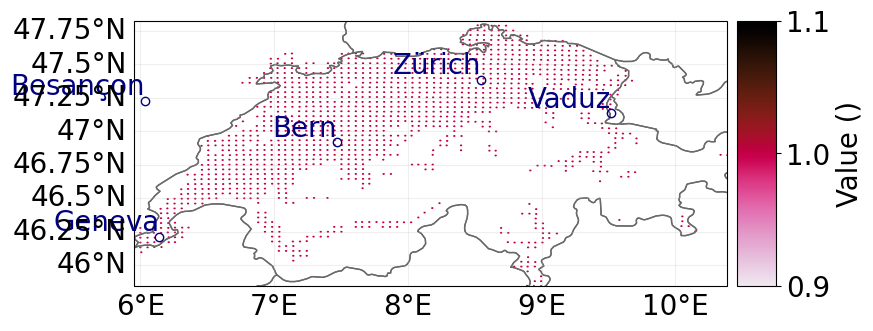

In [4]:
exp_new.plot_hexbin()

In [36]:
impact_metric='n_fields_dmg'

for resolution in [8,4,2,1]:
    for croptype in croptypes:
        filename_dmg=f"C:/Users/F80840370/projects/scClim/climada/data/scClim/impact/damage_claims/gridded/damage_claims_SHV_{croptype}_gridded_{resolution}km.nc"
        damages=read_gridded_damages_as_impact(filename_dmg,impact_metric='n_fields_dmg', binary_damage=False)

        if en_names[croptype]=='field crops':
            name='field_crops'
        else:
            name=en_names[croptype]
        filename_out=f"C:/Users/F80840370/projects/scClim/climada/data/scClim/impact/damage_claims/gridded/hdf5/hail_damage_CH_{name}_{resolution}km.h5"
        damages.haz_type='HL'
        damages.unit='number of fields'
        damages.write_hdf5(filename_out)


In [5]:
croptype='field_crops'
resolution=8
filename_out=f"C:/Users/F80840370/projects/scClim/climada/data/scClim/impact/damage_claims/gridded/hdf5/hail_damage_CH_{croptype}_{resolution}km.h5"
dmgs=Impact.from_hdf5(filename_out)



<GeoAxes: >

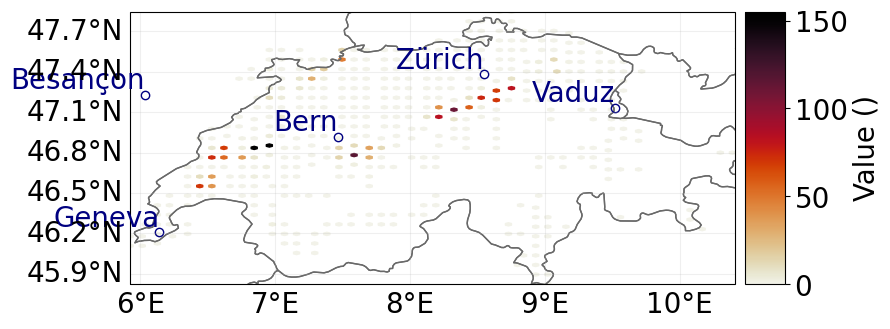

In [25]:
impact_now=dmgs.select(event_names=['ev_2021-06-21'])
impact_now.plot_hexbin_impact_exposure(event_id=impact_now.event_id[0], gridsize=100)


In [26]:
indices=dmgs.imp_mat.nonzero()
imp_mat_binary=dmgs.imp_mat.copy()
imp_mat_binary[indices]=1
dmgs.imp_mat=imp_mat_binary

<GeoAxes: >

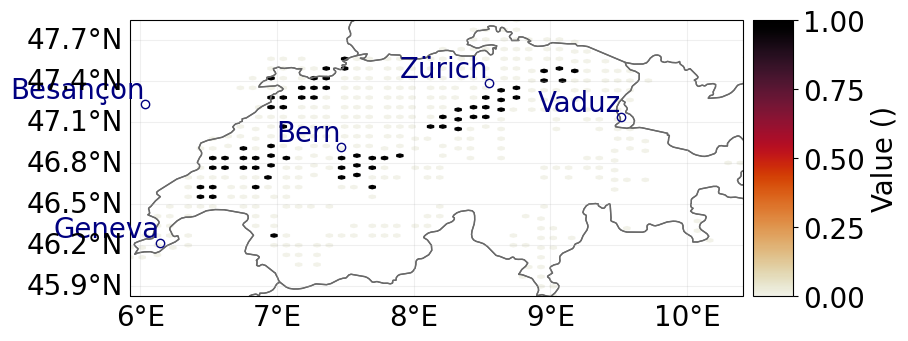

In [27]:
impact_now=dmgs.select(event_names=['ev_2021-06-21'])
impact_now.plot_hexbin_impact_exposure(event_id=impact_now.event_id[0], gridsize=100)

Now the same for hazard data

In [46]:
#if only original 1km hazard data is available
startyear=2017
endyear=2021
hazard_filedir = 'C:/Users/F80840370/projects/scClim/climada/data/scClim/hazard/radar/v5/MZC/'
hazard_filedir_POH = 'C:/Users/F80840370/projects/scClim/climada/data/scClim/hazard/radar/v5/BZC/'

filenames = [hazard_filedir+'MZC_X1d66_'+str(yyyy)+'.nc' for yyyy in np.arange(startyear,endyear+1,1)]
filenames_POH = [hazard_filedir_POH+'BZC_X1d66_'+str(yyyy)+'.nc' for yyyy in np.arange(startyear,endyear+1,1)]

hazard_1km=hazard_from_radar(filenames_POH, varname='POH', time_dim = 'time',spatial_dims = ['chy','chx'])


c:\Users\F80840370\Anaconda3\envs\climada_env_3.9\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
c:\Users\F80840370\Anaconda3\envs\climada_env_3.9\lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
c:\Users\F80840370\Anaconda3\envs\climada_env_3.9\lib\site-packages\xarray\core\variable.py:1786: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}

In [47]:
import pandas as pd
names=[pd.Timestamp.fromordinal(d).strftime('ev_%Y-%m-%d') for d in dmgs.date]
haz_sel=hazard_1km.select(event_names=names)

In [48]:
filename='C:/Users/F80840370/projects/scClim/climada/data/scClim/hazard/radar/v5/hail_POH_CH_12_events_2017_2021.h5'
haz_sel.event_id=np.arange(1,len(haz_sel.event_id)+1,1)
haz_sel.write_hdf5(filename)

In [49]:
haz_read=Hazard.from_hdf5(filename)

In [52]:
haz_read.event_name

['ev_2017-06-27',
 'ev_2017-07-08',
 'ev_2017-08-01',
 'ev_2019-06-15',
 'ev_2019-06-30',
 'ev_2019-07-01',
 'ev_2021-06-20',
 'ev_2021-06-21',
 'ev_2021-06-28',
 'ev_2021-07-12',
 'ev_2021-07-13',
 'ev_2021-07-24']

<GeoAxes: title={'center': 'Event ID 1: ev_2017-06-27'}>

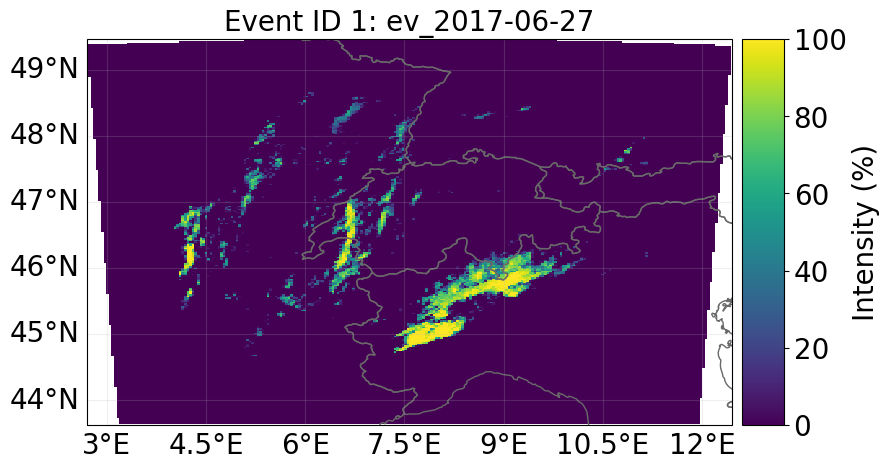

In [51]:
haz_read.plot_intensity(event=1)